In [1]:
"""
Pipeline training mô hình phát hiện rò rỉ
"""
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("[WARNING] CatBoost not installed. Install: pip install catboost")

In [3]:
print("="*80)
print("TRAINING MO HINH PHAT HIEN RO RI")
print("="*80)

TRAINING MO HINH PHAT HIEN RO RI


In [4]:
# 1. Load và Preprocess Data
print("\n1. LOAD VA PREPROCESS DATA:")
print("-" * 80)


1. LOAD VA PREPROCESS DATA:
--------------------------------------------------------------------------------


In [5]:
# FIX: Tự động tìm project root (hỗ trợ cả notebooks/ và notebook/)
import os
print(f"📂 Current working directory: {os.getcwd()}")

current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)

# Strategy 1: Nếu đang ở trong notebooks/ hoặc notebook/, đi lên 1 cấp
if current_dir_name in ['notebooks', 'notebook']:
    project_root = os.path.dirname(current_dir)
    os.chdir(project_root)
    print(f"✅ Changed from '{current_dir_name}/' to: {os.getcwd()}")
    project_root = os.getcwd()
    
# Strategy 2: Nếu đang ở root (/), tìm project directory
elif current_dir == '/':
    print("⚠️  Currently at root directory (/), searching for project directory...")
    
    # Tìm các thư mục có thể là project (có dataset/ và notebook hoặc notebooks)
    possible_projects = []
    try:
        root_contents = [d for d in os.listdir('/') if os.path.isdir(os.path.join('/', d)) and not d.startswith('.')]
        print(f"   Found {len(root_contents)} directories in root")
        
        for dir_name in root_contents:
            dir_path = os.path.join('/', dir_name)
            dataset_path = os.path.join(dir_path, 'dataset')
            notebook_path = os.path.join(dir_path, 'notebook')
            notebooks_path = os.path.join(dir_path, 'notebooks')
            
            # Kiểm tra có dataset/ và (notebook/ hoặc notebooks/)
            if os.path.isdir(dataset_path) and (os.path.isdir(notebook_path) or os.path.isdir(notebooks_path)):
                possible_projects.append(dir_path)
                print(f"   ✅ Found project candidate: {dir_path}")
        
        if len(possible_projects) == 1:
            project_root = possible_projects[0]
            os.chdir(project_root)
            print(f"✅ Changed to project directory: {project_root}")
        elif len(possible_projects) > 1:
            # Chọn project đầu tiên (có thể là 'epanet')
            if 'epanet' in [os.path.basename(p) for p in possible_projects]:
                project_root = [p for p in possible_projects if os.path.basename(p) == 'epanet'][0]
            else:
                project_root = possible_projects[0]
            os.chdir(project_root)
            print(f"⚠️  Multiple projects found, using: {project_root}")
        else:
            # Không tìm thấy, thử 'epanet' hoặc home directory
            home_dir = os.path.expanduser('~')
            epanet_path = os.path.join(home_dir, 'epanet')
            if os.path.isdir(epanet_path):
                project_root = epanet_path
                os.chdir(project_root)
                print(f"✅ Changed to: {project_root}")
            else:
                raise FileNotFoundError("Could not find project directory. Please run notebook from project root or /epanet directory.")
    except Exception as e:
        print(f"   ⚠️  Error searching: {e}")
        raise FileNotFoundError("Could not find project directory. Please run notebook from project root.")

# Strategy 3: Đã ở project root
else:
    project_root = current_dir
    print(f"✅ Already in directory: {project_root}")

# QUAN TRỌNG: Dùng project_root để build path (không dùng Path("dataset") vì sẽ resolve từ current dir)
dataset_dir = Path(project_root) / "dataset"

print(f"\n📁 Looking for dataset:")
print(f"   Project root: {project_root}")
print(f"   Dataset path: {dataset_dir}")
print(f"   Dataset absolute: {dataset_dir.absolute()}")

# Kiểm tra dataset có tồn tại không
if not dataset_dir.exists():
    print(f"\n❌ Dataset directory not found!")
    print(f"   Expected: {dataset_dir.absolute()}")
    print(f"   Current working directory: {os.getcwd()}")
    print(f"   Contents of project root:")
    try:
        contents = sorted(os.listdir(project_root))
        for item in contents[:15]:
            item_path = os.path.join(project_root, item)
            item_type = "DIR" if os.path.isdir(item_path) else "FILE"
            print(f"     [{item_type}] {item}")
        if len(contents) > 15:
            print(f"     ... and {len(contents) - 15} more items")
    except Exception as e:
        print(f"     ⚠️  Error: {e}")
    print(f"\n   💡 Tip: Ensure 'dataset/' folder exists in project root!")
    raise FileNotFoundError(f"Dataset directory not found: {dataset_dir.absolute()}")
else:
    print(f"✅ Dataset directory exists!")

# Support cả old structure (file trực tiếp) và new structure (file trong subdir)
parquet_files_direct = sorted(dataset_dir.glob("scenario_*.parquet"))
parquet_files_subdir = []
for scenario_dir in sorted(dataset_dir.glob("scenario_*")):
    if scenario_dir.is_dir():
        # New structure: tìm nodes.parquet trong subdirectory
        nodes_file = scenario_dir / "nodes.parquet"
        if nodes_file.exists():
            parquet_files_subdir.append(nodes_file)
        # Hoặc tìm bất kỳ parquet nào trong subdir (fallback)
        elif not parquet_files_subdir:
            parquet_in_dir = list(scenario_dir.glob("*.parquet"))
            if parquet_in_dir:
                parquet_files_subdir.extend(parquet_in_dir)
parquet_files = sorted(parquet_files_direct + parquet_files_subdir)

📂 Current working directory: /home/nam/epanet/notebook
✅ Changed from 'notebook/' to: /home/nam/epanet

📁 Looking for dataset:
   Project root: /home/nam/epanet
   Dataset path: /home/nam/epanet/dataset
   Dataset absolute: /home/nam/epanet/dataset
✅ Dataset directory exists!


In [6]:
if len(parquet_files) == 0:
    print("\n❌ [ERROR] Không tìm thấy parquet files trong dataset/")
    print(f"   📂 Searched in: {dataset_dir.absolute()}")
    
    # Debug: Kiểm tra nội dung dataset directory
    print(f"\n   📋 Contents of dataset directory:")
    try:
        dataset_contents = sorted(os.listdir(dataset_dir))
        print(f"   Total items: {len(dataset_contents)}")
        for item in dataset_contents[:20]:
            item_path = dataset_dir / item
            item_type = "DIR" if item_path.is_dir() else "FILE"
            print(f"     [{item_type}] {item}")
        if len(dataset_contents) > 20:
            print(f"     ... and {len(dataset_contents) - 20} more items")
        
        # Kiểm tra scenario folders
        scenario_dirs_check = [d for d in dataset_dir.iterdir() if d.is_dir() and d.name.startswith('scenario_')]
        print(f"\n   📊 Scenario directories found: {len(scenario_dirs_check)}")
        if len(scenario_dirs_check) > 0:
            print(f"   Sample scenario directory: {scenario_dirs_check[0]}")
            sample_contents = list(scenario_dirs_check[0].iterdir())
            print(f"   Contents of {scenario_dirs_check[0].name}:")
            for item in sample_contents[:5]:
                print(f"     - {item.name} ({'DIR' if item.is_dir() else 'FILE'})")
    except Exception as e:
        print(f"   ⚠️  Could not list directory contents: {e}")
    
    print(f"\n   💡 Tip: Đảm bảo bạn đã chạy generate_leak_scenarios.py trước!")
    raise FileNotFoundError(f"No parquet files found in {dataset_dir.absolute()}")

In [7]:
print(f"✅ Tìm thấy {len(parquet_files)} scenarios")
print(f"   📊 First scenario: {parquet_files[0]}")

✅ Tìm thấy 1500 scenarios
   📊 First scenario: /home/nam/epanet/dataset/scenario_00001/nodes.parquet


In [8]:
# Load sample để check structure
df_sample = pd.read_parquet(parquet_files[0])
print(f"[OK] Sample shape: {df_sample.shape}")
print(f"[OK] Columns: {list(df_sample.columns)}")

[OK] Sample shape: (18818, 7)
[OK] Columns: ['timestamp', 'pressure', 'head', 'demand', 'leak_demand', 'node_id', 'scenario_id']


FIX: Tạm bỏ filter reservoir để tránh loại nhầm junction
(Nếu có metadata node type từ INP thì nên dùng metadata đó)
reservoir_nodes = df_sample[df_sample['demand'] < -0.1]['node_id'].unique().tolist()
print(f"[INFO] Reservoir nodes: {reservoir_nodes}")

In [9]:
# Load tất cả data
print("\n[INFO] Dang load data...")
print("[INFO] Loading FULL dataset (all scenarios)")


[INFO] Dang load data...
[INFO] Loading FULL dataset (all scenarios)


In [10]:
# ⚙️ CẤU HÌNH SỐ LƯỢNG SCENARIOS
# ====================================
# 💡 TẠO THÊM SCENARIOS = MODEL TỐT HƠN!
# - Hiện có: 1500 scenarios trong dataset
# - Server RAM: 31GB (29GB available) → Có thể load hết 1500 scenarios!
#
# 📊 Bảng tham khảo:
#   - 500 scenarios:  ~9.4M records, Top-5 ~38%, Memory: 8GB+
#   - 1500 scenarios: ~28M records, Top-5 ~42%, Memory: 24GB+ ✅ PHÙ HỢP SERVER
#   - 3000 scenarios: ~56M records, Top-5 ~48%, Memory: 48GB+ (cần generate thêm)
#
# 🚀 Với 31GB RAM: Có thể dùng hết 1500 scenarios không vấn đề!
# 💡 Để có kết quả tốt hơn nữa: Tạo thêm 1500 scenarios → tổng 3000 (xem TRAINING_STRATEGY.md)
# ====================================

# Chọn số lượng scenarios để train:
# Option 1: None (tất cả scenarios có sẵn) - KHUYẾN NGHỊ cho server!
# Option 2: 1500 (dùng hết dataset hiện có)
# Option 3: 3000+ (cần generate thêm scenarios trước)
max_scenarios = None  # ✅ Dùng TẤT CẢ scenarios có sẵn (tối ưu nhất cho server!)

print(f"\n{'='*60}")
print(f"📊 Dataset Configuration:")
print(f"   Total scenarios available: {len(parquet_files)}")
print(f"   Training with: {max_scenarios if max_scenarios else 'ALL'} scenarios")
if max_scenarios:
    estimated_records = int(max_scenarios * 18818)  # ~18818 records/scenario
    print(f"   Estimated records: ~{estimated_records:,}")
    print(f"   Estimated RAM: ~{estimated_records * 0.003:.1f} GB")
else:
    estimated_records = len(parquet_files) * 18818
    print(f"   Estimated records: ~{estimated_records:,}")
    print(f"   Estimated RAM: ~{estimated_records * 0.003:.1f} GB")
print(f"{'='*60}\n")

files_to_load = parquet_files[:max_scenarios] if max_scenarios else parquet_files
print(f"✅ Đã chọn {len(files_to_load)} files để load")


📊 Dataset Configuration:
   Total scenarios available: 1500
   Training with: ALL scenarios
   Estimated records: ~28,227,000
   Estimated RAM: ~84681.0 GB

✅ Đã chọn 1500 files để load


In [11]:
dfs = []
import time
start_load_time = time.time()
for i, f in enumerate(files_to_load):
    dfs.append(pd.read_parquet(f))
    if (i + 1) % 100 == 0 or (i + 1) == len(files_to_load):
        elapsed = time.time() - start_load_time
        rate = (i + 1) / elapsed if elapsed > 0 else 0
        remaining = (len(files_to_load) - i - 1) / rate if rate > 0 else 0
        print(f"  Loaded {i+1}/{len(files_to_load)} files... ({elapsed:.1f}s, ~{remaining:.1f}s remaining)")

  Loaded 100/1500 files... (0.6s, ~8.5s remaining)
  Loaded 200/1500 files... (1.3s, ~8.2s remaining)
  Loaded 300/1500 files... (1.9s, ~7.7s remaining)
  Loaded 400/1500 files... (2.7s, ~7.4s remaining)
  Loaded 500/1500 files... (3.3s, ~6.6s remaining)
  Loaded 600/1500 files... (4.0s, ~6.0s remaining)
  Loaded 700/1500 files... (4.6s, ~5.3s remaining)
  Loaded 800/1500 files... (5.2s, ~4.6s remaining)
  Loaded 900/1500 files... (6.0s, ~4.0s remaining)
  Loaded 1000/1500 files... (6.7s, ~3.4s remaining)
  Loaded 1100/1500 files... (7.4s, ~2.7s remaining)
  Loaded 1200/1500 files... (8.0s, ~2.0s remaining)
  Loaded 1300/1500 files... (8.7s, ~1.3s remaining)
  Loaded 1400/1500 files... (9.4s, ~0.7s remaining)
  Loaded 1500/1500 files... (10.2s, ~0.0s remaining)


In [12]:
df_all = pd.concat(dfs, ignore_index=True)
print(f"[OK] Total records: {len(df_all):,}")

[OK] Total records: 28,227,000


In [13]:
# FIX: Tạm bỏ filter reservoir để tránh loại nhầm junction
# print("\n[INFO] Filtering reservoir nodes...")
# df_ml = df_all[~df_all['node_id'].isin(reservoir_nodes)].copy()
df_ml = df_all.copy()
print(f"[OK] Using all records: {len(df_ml):,} records")
print(f"[OK] Total nodes: {df_ml['node_id'].nunique()}")

[OK] Using all records: 28,227,000 records
[OK] Total nodes: 194


In [14]:
# 2. Correct Labeling: (node == leak_node) & (t in [t0, t1])
print("\n2. LABELING (node==leak_node & t in [t0,t1]):")
print("-" * 80)


2. LABELING (node==leak_node & t in [t0,t1]):
--------------------------------------------------------------------------------


In [15]:
# Load metadata
metadata = pd.read_csv(dataset_dir / "metadata.csv")
scenarios_in_data = df_ml['scenario_id'].unique()
metadata = metadata[metadata['scenario_id'].isin(scenarios_in_data)].copy()
metadata = metadata.sort_values('scenario_id')

In [16]:
# FIX: Chuẩn hóa tên cột metadata (support cả start_time_s/end_time_s và leak_start_time_s/leak_end_time_s)
if 'start_time_s' not in metadata.columns and 'leak_start_time_s' in metadata.columns:
    metadata['start_time_s'] = metadata['leak_start_time_s']
if 'end_time_s' not in metadata.columns and 'leak_end_time_s' in metadata.columns:
    metadata['end_time_s'] = metadata['leak_end_time_s']

In [17]:
print(f"[INFO] Processing {len(metadata)} scenarios for labeling...")

[INFO] Processing 1500 scenarios for labeling...


In [18]:
# Initialize labels
df_ml['has_leak'] = 0

In [19]:
# Old labeling for comparison (will be removed)
df_ml['has_leak_old'] = (df_ml['leak_demand'] > 0).astype(int)

In [20]:
# OPTIMIZED: Vectorized labeling for maximum speed (supports multiple leaks per scenario)
print("[INFO] Vectorizing labeling process...")
start_label_time = time.time()

[INFO] Vectorizing labeling process...


In [21]:
# Check if metadata has multiple leaks per scenario (new format)
if 'leak_nodes' in metadata.columns and 'n_leaks' in metadata.columns:
    print("[INFO] Detected multiple leaks per scenario format")
    # Expand metadata to have one row per leak
    expanded_rows = []
    for _, row in metadata.iterrows():
        scenario_id = row['scenario_id']
        leak_nodes = eval(row['leak_nodes']) if isinstance(row['leak_nodes'], str) else row['leak_nodes']
        leak_start_times = eval(row['leak_start_times_s']) if isinstance(row['leak_start_times_s'], str) else row['leak_start_times_s']
        leak_end_times = eval(row['leak_end_times_s']) if isinstance(row['leak_end_times_s'], str) else row['leak_end_times_s']
        
        for i, leak_node in enumerate(leak_nodes):
            expanded_rows.append({
                'scenario_id': scenario_id,
                'leak_node': leak_node,
                'start_time_s': leak_start_times[i],
                'end_time_s': leak_end_times[i]
            })
    
    metadata_expanded = pd.DataFrame(expanded_rows)
    print(f"[INFO] Expanded {len(metadata)} scenarios to {len(metadata_expanded)} leak instances")
else:
    # Single leak per scenario (backward compatible)
    metadata_expanded = metadata[['scenario_id', 'leak_node', 'start_time_s', 'end_time_s']].copy()

[INFO] Detected multiple leaks per scenario format
[INFO] Expanded 1500 scenarios to 15000 leak instances


In [22]:
# Convert leak info to dictionary for fast lookup (avoid huge merge)
print("[INFO] Building leak lookup dictionary...")
leak_lookup = {}
for _, row in metadata_expanded.iterrows():
    scenario_id = row['scenario_id']
    if scenario_id not in leak_lookup:
        leak_lookup[scenario_id] = []
    leak_lookup[scenario_id].append({
        'leak_node': str(int(float(row['leak_node']))) if '.' in str(row['leak_node']) else str(row['leak_node']),
        'start_time_s': row['start_time_s'],
        'end_time_s': row['end_time_s']
    })

[INFO] Building leak lookup dictionary...


In [23]:
# Convert node_id to string for comparison
df_ml['node_id_str'] = df_ml['node_id'].astype(str)

In [24]:
# Initialize label column
df_ml['has_leak'] = 0

In [25]:
print("[INFO] Labeling by scenario groups (optimized to avoid full scans)...")
# Group by scenario_id first to avoid repeated full scans
grouped = df_ml.groupby('scenario_id', sort=False)
total_scenarios = len(leak_lookup)
processed = 0

[INFO] Labeling by scenario groups (optimized to avoid full scans)...


In [26]:
for scenario_id, scenario_df in grouped:
    processed += 1
    if processed % 50 == 0 or processed == total_scenarios:
        print(f"[INFO] Processed {processed}/{total_scenarios} scenarios...")
    
    # Get leak info for this scenario
    if scenario_id not in leak_lookup:
        continue
    
    scenario_leaks = leak_lookup[scenario_id]
    
    # Get indices for this scenario group
    scenario_indices = scenario_df.index
    
    # For each leak in this scenario
    for leak_info in scenario_leaks:
        # Find matching rows within this scenario: (node == leak_node) & (timestamp in [start, end])
        leak_mask = (
            (scenario_df['node_id_str'] == leak_info['leak_node']) &
            (scenario_df['timestamp'] >= leak_info['start_time_s']) &
            (scenario_df['timestamp'] <= leak_info['end_time_s'])
        )
        # Update only matching indices
        matching_indices = scenario_indices[leak_mask]
        if len(matching_indices) > 0:
            df_ml.loc[matching_indices, 'has_leak'] = 1

[INFO] Processed 50/1500 scenarios...
[INFO] Processed 100/1500 scenarios...
[INFO] Processed 150/1500 scenarios...
[INFO] Processed 200/1500 scenarios...
[INFO] Processed 250/1500 scenarios...
[INFO] Processed 300/1500 scenarios...
[INFO] Processed 350/1500 scenarios...
[INFO] Processed 400/1500 scenarios...
[INFO] Processed 450/1500 scenarios...
[INFO] Processed 500/1500 scenarios...
[INFO] Processed 550/1500 scenarios...
[INFO] Processed 600/1500 scenarios...
[INFO] Processed 650/1500 scenarios...
[INFO] Processed 700/1500 scenarios...
[INFO] Processed 750/1500 scenarios...
[INFO] Processed 800/1500 scenarios...
[INFO] Processed 850/1500 scenarios...
[INFO] Processed 900/1500 scenarios...
[INFO] Processed 950/1500 scenarios...
[INFO] Processed 1000/1500 scenarios...
[INFO] Processed 1050/1500 scenarios...
[INFO] Processed 1100/1500 scenarios...
[INFO] Processed 1150/1500 scenarios...
[INFO] Processed 1200/1500 scenarios...
[INFO] Processed 1250/1500 scenarios...
[INFO] Processed 130

In [27]:
# Clean up temporary column
df_ml.drop(['node_id_str'], axis=1, inplace=True, errors='ignore')

In [28]:
elapsed = time.time() - start_label_time
print(f"[OK] Labeling completed in {elapsed:.1f}s (vectorized)")

[OK] Labeling completed in 29.3s (vectorized)


In [29]:
# Compare old vs new labeling
leak_ratio_old = df_ml['has_leak_old'].mean()
leak_ratio_new = df_ml['has_leak'].mean()

In [30]:
print(f"[OK] Labeling comparison:")
print(f"  Old (leak_demand > 0): {df_ml['has_leak_old'].sum():,} ({100*leak_ratio_old:.4f}%)")
print(f"  New (exact leak_node): {df_ml['has_leak'].sum():,} ({100*leak_ratio_new:.4f}%)")
print(f"  [INFO] Using new labeling for training")

[OK] Labeling comparison:
  Old (leak_demand > 0): 372,052 (1.3181%)
  New (exact leak_node): 381,270 (1.3507%)
  [INFO] Using new labeling for training


In [31]:
# 3. Feature Engineering
print("\n3. FEATURE ENGINEERING:")
print("-" * 80)


3. FEATURE ENGINEERING:
--------------------------------------------------------------------------------


In [32]:
# Time features
df_ml['hour'] = (df_ml['timestamp'] / 3600).astype(int)
# REMOVED: hour_sin, hour_cos to prevent time-based bias
# Model should learn from hydraulic signals, not time-of-day patterns
# df_ml['hour_sin'] = np.sin(2 * np.pi * df_ml['hour'] / 24)
# df_ml['hour_cos'] = np.cos(2 * np.pi * df_ml['hour'] / 24)
print("[OK] Time features REMOVED to prevent time-based learning bias")

[OK] Time features REMOVED to prevent time-based learning bias


In [33]:
# Enhanced features: pressure changes, moving averages
print("[INFO] Adding enhanced features...")
print("[INFO] Optimizing with scenario-wise processing for memory efficiency...")
import time
feat_start = time.time()

[INFO] Adding enhanced features...
[INFO] Optimizing with scenario-wise processing for memory efficiency...


In [34]:
# FIX: MEMORY EFFICIENT - Use groupby(['scenario_id', 'node_id']) with transform
# NO sorting needed, NO loop, pandas handles everything efficiently
print("[INFO] Computing features with groupby(['scenario_id', 'node_id']).transform()...")
print("[INFO] This is memory efficient and fast (single pass over data)...")

[INFO] Computing features with groupby(['scenario_id', 'node_id']).transform()...
[INFO] This is memory efficient and fast (single pass over data)...


In [35]:
# Group by scenario_id AND node_id at once (ensures no leakage between scenarios)
g = df_ml.groupby(['scenario_id', 'node_id'], sort=False)

In [36]:
# Pressure/Head changes (diff within each scenario-node group)
print("  Computing pressure_change, head_change...")
df_ml['pressure_change'] = g['pressure'].transform(lambda x: x.diff().fillna(0))
df_ml['head_change'] = g['head'].transform(lambda x: x.diff().fillna(0))

  Computing pressure_change, head_change...


In [37]:
# Moving averages (rolling within each scenario-node group)
print("  Computing moving averages (MA3, MA5)...")
df_ml['pressure_ma5'] = g['pressure'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df_ml['head_ma5'] = g['head'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df_ml['pressure_ma3'] = g['pressure'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df_ml['head_ma3'] = g['head'].transform(lambda x: x.rolling(3, min_periods=1).mean())

  Computing moving averages (MA3, MA5)...


In [38]:
# Pressure/Head drops (rolling max - current within each scenario-node group)
print("  Computing pressure_drop, head_drop...")
pressure_max = g['pressure'].transform(lambda x: x.rolling(5, min_periods=1).max())
head_max = g['head'].transform(lambda x: x.rolling(5, min_periods=1).max())
df_ml['pressure_drop'] = pressure_max - df_ml['pressure']
df_ml['head_drop'] = head_max - df_ml['head']

  Computing pressure_drop, head_drop...


In [39]:
print(f"  [OK] Enhanced features completed in {time.time() - feat_start:.1f}s")

  [OK] Enhanced features completed in 375.3s


In [40]:
# Add SPATIAL features (network-level statistics - no topology needed!)
print("[INFO] Adding spatial features (network-level statistics)...")
spatial_start = time.time()

[INFO] Adding spatial features (network-level statistics)...


In [41]:
# Network-wide statistics at each timestep (captures global anomalies)
df_ml['network_pressure_mean'] = df_ml.groupby(['scenario_id', 'timestamp'])['pressure'].transform('mean')
df_ml['network_pressure_std'] = df_ml.groupby(['scenario_id', 'timestamp'])['pressure'].transform('std')
df_ml['network_demand_mean'] = df_ml.groupby(['scenario_id', 'timestamp'])['demand'].transform('mean')

In [42]:
# Node deviation from network (leak creates local anomalies)
df_ml['pressure_deviation'] = df_ml['pressure'] - df_ml['network_pressure_mean']
# FIX: Calculate demand_deviation per scenario to prevent leakage between train/val/test
df_ml['demand_deviation'] = df_ml.groupby(['scenario_id', 'node_id'])['demand'].transform(lambda x: x - x.mean())

In [43]:
print(f"  [OK] Spatial features completed in {time.time() - spatial_start:.1f}s")

  [OK] Spatial features completed in 48.9s


In [44]:
# REMOVED: node_id_int, leak_node, scenario_id (to prevent data leakage)
print("[OK] REMOVED: node_id_int, leak_node, scenario_id from features")

[OK] REMOVED: node_id_int, leak_node, scenario_id from features


In [ ]:
# 🚀 ADVANCED FEATURES (Statistical & Rolling Statistics)
# ==========================================
# Thêm features để cải thiện model performance
# ⚠️  OPTIMIZED: Tính từng feature với progress để tránh treo

print("\n[INFO] Adding ADVANCED features for better model performance...")
print(f"   Dataset size: {len(df_ml):,} records - This may take 2-5 minutes...")

# OPTION: Có thể bỏ qua một số features nếu quá chậm
USE_FULL_ADVANCED_FEATURES = True  # Set False để chỉ tính features quan trọng nhất

import time
adv_start = time.time()
g = df_ml.groupby(['scenario_id', 'node_id'], sort=False)

# Rolling standard deviation (detect anomalies)
if USE_FULL_ADVANCED_FEATURES:
    print("  1/9 Computing rolling std...")
    start = time.time()
    df_ml['pressure_std_5'] = g['pressure'].transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))
    print(f"      pressure_std_5 done ({time.time()-start:.1f}s)")
    start = time.time()
    df_ml['head_std_5'] = g['head'].transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))
    print(f"      head_std_5 done ({time.time()-start:.1f}s)")
    start = time.time()
    df_ml['demand_std_5'] = g['demand'].transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))
    print(f"      demand_std_5 done ({time.time()-start:.1f}s)")
else:
    print("  ⚠️  Skipping rolling std (USE_FULL_ADVANCED_FEATURES = False)")
    # Set default values
    df_ml['pressure_std_5'] = 0
    df_ml['head_std_5'] = 0
    df_ml['demand_std_5'] = 0

# Rolling min/max (detect sudden drops/increases) - QUAN TRỌNG, luôn tính
print("  2/9 Computing rolling min/max...")
start = time.time()
df_ml['pressure_min_5'] = g['pressure'].transform(lambda x: x.rolling(5, min_periods=1).min())
df_ml['pressure_max_5'] = g['pressure'].transform(lambda x: x.rolling(5, min_periods=1).max())
print(f"      pressure min/max done ({time.time()-start:.1f}s)")
start = time.time()
df_ml['head_min_5'] = g['head'].transform(lambda x: x.rolling(5, min_periods=1).min())
df_ml['head_max_5'] = g['head'].transform(lambda x: x.rolling(5, min_periods=1).max())
print(f"      head min/max done ({time.time()-start:.1f}s)")

# Rate of change (second derivative approximation)
print("  3/9 Computing acceleration...")
start = time.time()
df_ml['pressure_acceleration'] = g['pressure_change'].transform(lambda x: x.diff().fillna(0))
df_ml['head_acceleration'] = g['head_change'].transform(lambda x: x.diff().fillna(0))
print(f"      acceleration done ({time.time()-start:.1f}s)")

# Relative changes (percentage) - OPTIMIZED: tính nhanh hơn
print("  4/9 Computing relative changes (pct)...")
start = time.time()
# Tối ưu: tính từ pressure_change đã có thay vì pct_change (nhanh hơn)
df_ml['pressure_change_pct'] = df_ml['pressure_change'] / (df_ml['pressure'].abs() + 1e-6)
print(f"      pressure_change_pct done ({time.time()-start:.1f}s)")
start = time.time()
df_ml['head_change_pct'] = df_ml['head_change'] / (df_ml['head'].abs() + 1e-6)
print(f"      head_change_pct done ({time.time()-start:.1f}s)")
start = time.time()
# Demand change chưa có, tính nhanh với diff
demand_change = g['demand'].transform(lambda x: x.diff().fillna(0))
df_ml['demand_change_pct'] = demand_change / (df_ml['demand'].abs() + 1e-6)
del demand_change  # Free memory
print(f"      demand_change_pct done ({time.time()-start:.1f}s)")

# Pressure-to-demand ratio (simple calculation, fast)
print("  5/9 Computing ratios...")
start = time.time()
df_ml['pressure_demand_ratio'] = df_ml['pressure'] / (df_ml['demand'].abs() + 1e-6)
df_ml['head_demand_ratio'] = df_ml['head'] / (df_ml['demand'].abs() + 1e-6)
print(f"      ratios done ({time.time()-start:.1f}s)")

total_time = time.time() - adv_start
print(f"\n✅ Advanced features completed in {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   Total: 12 new features added")

# Feature columns (NO leak_node/scenario_id/node_id_int)
feature_cols = [
    # Basic features
    'pressure', 'head', 'demand',
    # Moving averages
    'pressure_ma3', 'pressure_ma5', 'head_ma3', 'head_ma5',
    # Temporal changes
    'pressure_change', 'head_change',
    'pressure_drop', 'head_drop',
    # Spatial features
    'network_pressure_mean', 'network_pressure_std', 'network_demand_mean',
    'pressure_deviation', 'demand_deviation',
    # 🚀 NEW: Advanced statistical features
    'pressure_std_5', 'head_std_5', 'demand_std_5',
    'pressure_min_5', 'pressure_max_5', 'head_min_5', 'head_max_5',
    'pressure_acceleration', 'head_acceleration',
    'pressure_change_pct', 'head_change_pct', 'demand_change_pct',
    'pressure_demand_ratio', 'head_demand_ratio'
]
print(f"[OK] Total features: {len(feature_cols)} features")
print(f"  📊 Basic: 16 | Advanced: 12 | Total: {len(feature_cols)}")


[INFO] Adding ADVANCED features for better model performance...
   Dataset size: 28,227,000 records - This may take 2-5 minutes...
  1/9 Computing rolling std...
      pressure_std_5 done (72.5s)
      head_std_5 done (70.3s)
      demand_std_5 done (69.3s)
  2/9 Computing rolling min/max...
      pressure min/max done (87.2s)
      head min/max done (86.5s)
  3/9 Computing acceleration...
      acceleration done (108.4s)
  4/9 Computing relative changes (pct)...
      pressure_change_pct done (0.2s)
      head_change_pct done (0.2s)
      demand_change_pct done (53.9s)
  5/9 Computing ratios...
      ratios done (0.5s)

✅ Advanced features completed in 549.0s (9.2 minutes)
   Total: 12 new features added
[OK] Total features: 30 features
  📊 Basic: 16 | Advanced: 12 | Total: 30


In [46]:
# 4. Train/Val/Test Split
print("\n4. TRAIN/VAL/TEST SPLIT:")
print("-" * 80)


4. TRAIN/VAL/TEST SPLIT:
--------------------------------------------------------------------------------


In [47]:
# Stratified split by scenario để đảm bảo không leak giữa train/val/test
from sklearn.model_selection import train_test_split

In [48]:
# Split by scenario_id để tránh data leakage
scenario_ids = df_ml['scenario_id'].unique()
train_scenarios, temp_scenarios = train_test_split(
    scenario_ids, test_size=0.3, random_state=42
)
val_scenarios, test_scenarios = train_test_split(
    temp_scenarios, test_size=0.5, random_state=42
)

In [49]:
# OPTIMIZED: Use query() instead of isin() to avoid memory spike with boolean mask
# Convert to sets for fast lookup
train_scenarios_set = set(train_scenarios)
val_scenarios_set = set(val_scenarios)
test_scenarios_set = set(test_scenarios)

In [50]:
print("[INFO] Filtering datasets by scenario (using groupby to avoid memory spike)...")

[INFO] Filtering datasets by scenario (using groupby to avoid memory spike)...


In [51]:
# Process by groups to avoid creating large boolean masks
train_parts = []
val_parts = []
test_parts = []

In [52]:
for scenario_id, group_df in df_ml.groupby('scenario_id', sort=False):
    if scenario_id in train_scenarios_set:
        train_parts.append(group_df)
    elif scenario_id in val_scenarios_set:
        val_parts.append(group_df)
    elif scenario_id in test_scenarios_set:
        test_parts.append(group_df)

In [53]:
# OPTIMIZED: Extract features directly to avoid full DataFrame concat
# This reduces memory usage significantly
print("[INFO] Extracting features and labels (memory efficient)...")

[INFO] Extracting features and labels (memory efficient)...


In [54]:
X_train_parts = []
y_train_parts = []
X_val_parts = []
y_val_parts = []
X_test_parts = []
y_test_parts = []

In [55]:
for part in train_parts:
    X_train_parts.append(part[feature_cols])
    y_train_parts.append(part['has_leak'])

In [56]:
for part in val_parts:
    X_val_parts.append(part[feature_cols])
    y_val_parts.append(part['has_leak'])

In [57]:
# For test: also keep scenario_id and timestamp for per-scenario evaluation
test_meta_parts = []
for part in test_parts:
    X_test_parts.append(part[feature_cols])
    y_test_parts.append(part['has_leak'])
    # Keep metadata columns for evaluation
    test_meta_parts.append(part[['scenario_id', 'timestamp', 'node_id']])

In [58]:
# Concatenate only features and labels (much smaller than full DataFrame)
X_train = pd.concat(X_train_parts, ignore_index=True) if X_train_parts else pd.DataFrame()
y_train = pd.concat(y_train_parts, ignore_index=True) if y_train_parts else pd.Series()
X_val = pd.concat(X_val_parts, ignore_index=True) if X_val_parts else pd.DataFrame()
y_val = pd.concat(y_val_parts, ignore_index=True) if y_val_parts else pd.Series()
X_test = pd.concat(X_test_parts, ignore_index=True) if X_test_parts else pd.DataFrame()
y_test = pd.concat(y_test_parts, ignore_index=True) if y_test_parts else pd.Series()

In [59]:
# Concatenate test metadata for per-scenario evaluation
test_df_meta = pd.concat(test_meta_parts, ignore_index=True) if test_meta_parts else pd.DataFrame()

In [60]:
# Clean up to free memory
del train_parts, val_parts, test_parts
del X_train_parts, y_train_parts, X_val_parts, y_val_parts, X_test_parts, y_test_parts
del test_meta_parts

In [61]:
print(f"[OK] Train: {len(X_train):,} records ({len(train_scenarios)} scenarios)")
print(f"[OK] Val:   {len(X_val):,} records ({len(val_scenarios)} scenarios)")
print(f"[OK] Test:  {len(X_test):,} records ({len(test_scenarios)} scenarios)")

[OK] Train: 19,758,900 records (1050 scenarios)
[OK] Val:   4,234,050 records (225 scenarios)
[OK] Test:  4,234,050 records (225 scenarios)


In [62]:
# 5. Normalization (SKIPPED for CatBoost - works better with original features)
print("\n5. NORMALIZATION:")
print("-" * 80)
print("[INFO] CatBoost works better with original features, skipping StandardScaler")
print("[INFO] Using original feature values")


5. NORMALIZATION:
--------------------------------------------------------------------------------
[INFO] CatBoost works better with original features, skipping StandardScaler
[INFO] Using original feature values


In [63]:
# For CatBoost, use original features (no scaling needed)
X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

In [64]:
# Keep scaler as None for consistency (but won't be used)
scaler = None

In [65]:
# 6. Handle Class Imbalance
print("\n6. HANDLE CLASS IMBALANCE:")
print("-" * 80)


6. HANDLE CLASS IMBALANCE:
--------------------------------------------------------------------------------


In [66]:
# Check imbalance
print(f"[INFO] Class distribution:")
print(f"  No Leak: {(y_train == 0).sum():,} ({100*(y_train == 0).mean():.2f}%)")
print(f"  Leak:    {(y_train == 1).sum():,} ({100*(y_train == 1).mean():.2f}%)")

[INFO] Class distribution:
  No Leak: 19,492,042 (98.65%)
  Leak:    266,858 (1.35%)


In [67]:
# FIX: Bỏ SMOTE cho CatBoost (SMOTE có thể tạo điểm phi vật lý cho dữ liệu thủy lực)
# CatBoost xử lý tốt class imbalance với class_weights
print("\n[INFO] Using class_weights for CatBoost (no SMOTE - avoids non-physical synthetic points)")
X_train_balanced = X_train_scaled
y_train_balanced = y_train
use_smote = False


[INFO] Using class_weights for CatBoost (no SMOTE - avoids non-physical synthetic points)


In [68]:
# 7. Train Model
print("\n7. TRAINING MODEL:")
print("-" * 80)


7. TRAINING MODEL:
--------------------------------------------------------------------------------


In [69]:
if not CATBOOST_AVAILABLE:
    print("[ERROR] CatBoost not available!")
    print("  Install: pip install catboost")
    exit(1)

In [70]:
print("[INFO] Training CatBoostClassifier...")

[INFO] Training CatBoostClassifier...


In [71]:
# CatBoost parameters optimized for imbalanced data with spatial features
# HYBRID APPROACH: Increased capacity + better class weighting
# Calculate class weight (with higher multiplier for better recall)
base_weight = (len(y_train) - y_train.sum()) / y_train.sum() if y_train.sum() > 0 else 1.0
class_weight_multiplier = 15.0  # Increased from 10.0 to 15.0 (prioritize recall)
final_class_weight = min(1000.0, base_weight * class_weight_multiplier)  # Cap at 1000

In [72]:
# 🚀 GPU DETECTION & CONFIGURATION
# ==========================================
# Tự động phát hiện và cấu hình GPU cho CatBoost
# RTX 2080 với CUDA 13.0 sẽ được sử dụng nếu có!

import subprocess
import sys

# Check GPU availability
USE_GPU = True  # Set False để force CPU
task_type = 'CPU'  # Default

if USE_GPU:
    print("\n🔍 Checking GPU availability...")
    try:
        # Check nvidia-smi
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            print("✅ GPU detected via nvidia-smi!")
            
            # Extract GPU info
            lines = result.stdout.split('\n')
            for line in lines:
                if 'CUDA Version' in line:
                    cuda_version = line.split('CUDA Version:')[1].strip().split()[0]
                    print(f"   CUDA Version: {cuda_version}")
                if 'NVIDIA' in line and 'GeForce' in line:
                    gpu_name = line.split('|')[1].strip()
                    print(f"   GPU: {gpu_name}")
            
            # Test CatBoost GPU support
            print("\n🧪 Testing CatBoost GPU support...")
            try:
                from catboost import CatBoostClassifier
                # Quick test with tiny dataset
                test_model = CatBoostClassifier(
                    iterations=1,
                    task_type='GPU',
                    verbose=False,
                    devices='0:0'  # Use first GPU
                )
                # Create dummy data
                import numpy as np
                X_dummy = np.random.rand(100, 10)
                y_dummy = np.random.randint(0, 2, 100)
                test_model.fit(X_dummy, y_dummy)
                task_type = 'GPU'
                print("✅ CatBoost GPU test successful! Using GPU for training!")
                print("   🚀 Training will be MUCH faster on RTX 2080!")
                del test_model
            except Exception as gpu_error:
                print(f"⚠️  GPU available but CatBoost GPU test failed:")
                print(f"   Error: {str(gpu_error)[:100]}")
                print("   💡 Falling back to CPU (CPU training is still fast)")
                task_type = 'CPU'
        else:
            print("ℹ️  No GPU detected - using CPU")
            task_type = 'CPU'
    except FileNotFoundError:
        print("ℹ️  nvidia-smi not found - using CPU")
        task_type = 'CPU'
    except subprocess.TimeoutExpired:
        print("⚠️  nvidia-smi timeout - using CPU")
        task_type = 'CPU'
    except Exception as e:
        print(f"ℹ️  GPU check error: {e} - using CPU")
        task_type = 'CPU'
else:
    print("\n🔧 USE_GPU = False - Using CPU")
    task_type = 'CPU'

print(f"\n{'='*60}")
print(f"📊 Training Device: {task_type}")
if task_type == 'GPU':
    print(f"   GPU: RTX 2080 (CUDA 13.0)")
    print(f"   Expected speedup: 5-10x faster than CPU! 🚀")
print(f"{'='*60}\n")



🔍 Checking GPU availability...
✅ GPU detected via nvidia-smi!
   CUDA Version: 13.0
   GPU: 0  NVIDIA GeForce RTX 2080 ...    Off

🧪 Testing CatBoost GPU support...
✅ CatBoost GPU test successful! Using GPU for training!
   🚀 Training will be MUCH faster on RTX 2080!

📊 Training Device: GPU
   GPU: RTX 2080 (CUDA 13.0)
   Expected speedup: 5-10x faster than CPU! 🚀



In [73]:
print(f"[INFO] Class weight calculation (HYBRID - optimized):")
print(f"  Base ratio: {base_weight:.2f}")
print(f"  Multiplier: {class_weight_multiplier}x")
print(f"  Final weight: {final_class_weight:.2f}")

[INFO] Class weight calculation (HYBRID - optimized):
  Base ratio: 73.04
  Multiplier: 15.0x
  Final weight: 1000.00


In [74]:
# CatBoost parameters với GPU support
# task_type được set ở Cell 71 (GPU Detection) - nếu chưa chạy, mặc định CPU
try:
    task_type  # Kiểm tra xem biến đã được định nghĩa chưa
except NameError:
    print("⚠️  GPU detection cell (Cell 71) chưa chạy, sử dụng CPU")
    task_type = 'CPU'

catboost_params = {
    'iterations': 1000,  # Increased from 500 (allow more learning)
    'learning_rate': 0.05,  # Good learning rate for gradual convergence
    'depth': 12,  # Increased from 10 (more complex patterns with spatial features)
    'loss_function': 'Logloss',
    # ⚠️  METRIC: BalancedAccuracy không hỗ trợ GPU, dùng AUC cho GPU hoặc BalancedAccuracy cho CPU
    'eval_metric': 'AUC' if task_type == 'GPU' else 'BalancedAccuracy',  # AUC hỗ trợ GPU tốt hơn
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 100,  # Increased from 50 (more patient)
    'cat_features': [],  # No categorical features
    'class_weights': None if use_smote else [1.0, final_class_weight] if y_train.sum() > 0 else None,
    # Further reduced regularization for spatial features
    'l2_leaf_reg': 3,  # Reduced from 4 to 3 (spatial features need less regularization)
    'bootstrap_type': 'Bernoulli',  # FIX: Required for 'subsample' (Bayesian default doesn't support subsample)
    'subsample': 0.85,  # Increased from 0.8 to 0.85
    'rsm': 0.95,  # Increased from 0.9 to 0.95 (use almost all features)
    # 🚀 GPU CONFIGURATION (tự động từ cell GPU detection - Cell 71)
    'task_type': task_type,  # 'GPU' hoặc 'CPU'
}

# Nếu dùng GPU, chỉ định GPU device
if task_type == 'GPU':
    catboost_params['devices'] = '0:0'  # Use first GPU (RTX 2080)
    print("\n✅ GPU configuration added to CatBoost params:")
    print(f"   task_type: {task_type}")
    print(f"   devices: 0:0 (RTX 2080)")
    print(f"   🚀 Expected speedup: 5-10x faster than CPU!")
else:
    print("\nℹ️  Using CPU configuration for CatBoost")


✅ GPU configuration added to CatBoost params:
   task_type: GPU
   devices: 0:0 (RTX 2080)
   🚀 Expected speedup: 5-10x faster than CPU!


In [75]:
# Create CatBoost model
model = CatBoostClassifier(**catboost_params)

In [76]:
# 🎯 HYPERPARAMETER OPTIMIZATION (OPTIONAL - Uncomment to use)
# ==========================================
# Tối ưu hyperparameters để có kết quả tốt nhất
# ⚠️ LƯU Ý: Mất ~1-2 giờ để chạy, nhưng cải thiện đáng kể!

USE_HYPEROPT = False  # Set True để chạy optimization

if USE_HYPEROPT:
    print("\n[INFO] Starting hyperparameter optimization with Optuna...")
    print("  ⏱️  This will take 1-2 hours, but will find best parameters!")
    
    try:
        import optuna
        from optuna.samplers import TPESampler
        from sklearn.metrics import fbeta_score
        
        def objective(trial):
            """Objective function for Optuna"""
            params = {
                'iterations': trial.suggest_int('iterations', 800, 1500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                'depth': trial.suggest_int('depth', 8, 14),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),
                'bootstrap_type': 'Bernoulli',  # FIX: Required for 'subsample'
                'subsample': trial.suggest_float('subsample', 0.7, 0.95),
                'rsm': trial.suggest_float('rsm', 0.8, 1.0),
                'loss_function': 'Logloss',
                'eval_metric': 'BalancedAccuracy',
                'random_seed': 42,
                'verbose': False,
                'early_stopping_rounds': 100,
                'class_weights': None if use_smote else [1.0, final_class_weight] if y_train.sum() > 0 else None,
                # GPU support (nếu có)
                'task_type': task_type,  # Dùng GPU nếu đã detect
            }
            if task_type == 'GPU':
                params['devices'] = '0:0'  # Use first GPU
            
            model_trial = CatBoostClassifier(**params)
            model_trial.fit(
                X_train_array, y_train_array,
                eval_set=(X_val_array, y_val),
                use_best_model=True,
                verbose=False
            )
            
            # Use F2 score on validation set
            y_val_pred_proba = model_trial.predict_proba(X_val_array)[:, 1]
            best_f2 = 0
            for thresh in np.arange(0.1, 0.9, 0.05):
                y_val_pred = (y_val_pred_proba >= thresh).astype(int)
                if y_val_pred.sum() > 0:
                    f2 = fbeta_score(y_val, y_val_pred, beta=2.0, zero_division=0)
                    if f2 > best_f2:
                        best_f2 = f2
            return best_f2
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=30, timeout=7200)  # 30 trials or 2 hours
        
        print(f"\n✅ Best hyperparameters found:")
        print(f"   F2 Score: {study.best_value:.4f}")
        for key, value in study.best_params.items():
            print(f"   {key}: {value}")
        
        # Update catboost_params with best values
        for key, value in study.best_params.items():
            catboost_params[key] = value
        
    except ImportError:
        print("[WARNING] Optuna not installed. Install: pip install optuna")
        print("[INFO] Using default parameters...")
        USE_HYPEROPT = False
else:
    print("\n[INFO] Hyperparameter optimization SKIPPED (USE_HYPEROPT = False)")
    print("  💡 Set USE_HYPEROPT = True để tối ưu hyperparameters!")



[INFO] Hyperparameter optimization SKIPPED (USE_HYPEROPT = False)
  💡 Set USE_HYPEROPT = True để tối ưu hyperparameters!


In [77]:
# 🔍 DEBUG: Kiểm tra catboost_params trước khi tạo model
print("[DEBUG] Checking catboost_params...")
print(f"   bootstrap_type: {catboost_params.get('bootstrap_type', 'NOT SET (will use default Bayesian)')}")
print(f"   subsample: {catboost_params.get('subsample', 'NOT SET')}")

# Đảm bảo bootstrap_type được set đúng
if 'bootstrap_type' not in catboost_params and 'subsample' in catboost_params:
    print("\n⚠️  FIX: Adding bootstrap_type='Bernoulli' for subsample support")
    catboost_params['bootstrap_type'] = 'Bernoulli'
    print("✅ Fixed!")
elif 'bootstrap_type' in catboost_params:
    print(f"✅ bootstrap_type already set: {catboost_params['bootstrap_type']}")
else:
    print("✅ No subsample, bootstrap_type not needed")


[DEBUG] Checking catboost_params...
   bootstrap_type: Bernoulli
   subsample: 0.85
✅ bootstrap_type already set: Bernoulli


In [78]:
# Create CatBoost model
# ✅ Đảm bảo bootstrap_type được set trước khi tạo model
print("[INFO] Creating CatBoost model...")
if 'subsample' in catboost_params and 'bootstrap_type' not in catboost_params:
    catboost_params['bootstrap_type'] = 'Bernoulli'
    print("⚠️  Auto-fixed: Added bootstrap_type='Bernoulli' for subsample support")

# Tạo model với params đã fix
model = CatBoostClassifier(**catboost_params)
bootstrap_type_used = catboost_params.get('bootstrap_type', 'default (Bayesian)')
print(f"✅ Model created successfully!")
print(f"   bootstrap_type: {bootstrap_type_used}")
print(f"   subsample: {catboost_params.get('subsample', 'not set')}")

[INFO] Creating CatBoost model...
✅ Model created successfully!
   bootstrap_type: Bernoulli
   subsample: 0.85


In [79]:
# Fit model
print("[INFO] Training with CatBoost...")
# Convert to numpy arrays for CatBoost (faster)
X_train_array = X_train_balanced.values if isinstance(X_train_balanced, pd.DataFrame) else X_train_balanced
X_val_array = X_val_scaled.values if isinstance(X_val_scaled, pd.DataFrame) else X_val_scaled
y_train_array = y_train_balanced.values if isinstance(y_train_balanced, pd.Series) else y_train_balanced

[INFO] Training with CatBoost...


In [80]:
# ✅ CRITICAL FIX: Đảm bảo tất cả params đúng trước khi train
print("[INFO] Final check before training...")

# Fix 1: bootstrap_type cho subsample
if 'subsample' in catboost_params:
    if 'bootstrap_type' not in catboost_params or catboost_params.get('bootstrap_type') != 'Bernoulli':
        print("⚠️  CRITICAL: Fixing bootstrap_type for subsample support...")
        catboost_params['bootstrap_type'] = 'Bernoulli'
    else:
        print(f"✅ bootstrap_type already correct: {catboost_params['bootstrap_type']}")
else:
    print("ℹ️  No subsample parameter, bootstrap_type not needed")

# Fix 2: GPU không hỗ trợ rsm
task_type_current = catboost_params.get('task_type', 'CPU')
if task_type_current == 'GPU' and 'rsm' in catboost_params:
    print("⚠️  CRITICAL: Removing 'rsm' parameter (GPU doesn't support rsm)")
    del catboost_params['rsm']
    if 'devices' not in catboost_params:
        catboost_params['devices'] = '0:0'
    print("✅ rsm removed, devices set to '0:0'")
elif task_type_current == 'GPU':
    if 'devices' not in catboost_params:
        catboost_params['devices'] = '0:0'
        print("✅ GPU devices set to '0:0'")

# Tạo lại model với params đã fix
model = CatBoostClassifier(**catboost_params)
print(f"\n✅ Model recreated with correct params:")
print(f"   - task_type: {catboost_params.get('task_type', 'CPU')}")
print(f"   - bootstrap_type: {catboost_params.get('bootstrap_type', 'NOT SET')}")
print(f"   - subsample: {catboost_params.get('subsample', 'NOT SET')}")
print(f"   - rsm: {catboost_params.get('rsm', 'NOT SET (removed for GPU)')}")
if task_type_current == 'GPU':
    print(f"   - devices: {catboost_params.get('devices', 'NOT SET')}")

print("\n[INFO] Starting training...")
model.fit(
    X_train_array, y_train_array,
    eval_set=(X_val_array, y_val),
    use_best_model=True
)
print("[OK] Model trained!")

[INFO] Final check before training...
✅ bootstrap_type already correct: Bernoulli
⚠️  CRITICAL: Removing 'rsm' parameter (GPU doesn't support rsm)
✅ rsm removed, devices set to '0:0'

✅ Model recreated with correct params:
   - task_type: GPU
   - bootstrap_type: Bernoulli
   - subsample: 0.85
   - rsm: NOT SET (removed for GPU)
   - devices: 0:0

[INFO] Starting training...


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8206216	best: 0.8206216 (0)	total: 319ms	remaining: 5m 18s
100:	test: 0.8521190	best: 0.8521190 (100)	total: 20.1s	remaining: 2m 59s
200:	test: 0.8570509	best: 0.8570793 (197)	total: 43.4s	remaining: 2m 52s
300:	test: 0.8591252	best: 0.8591252 (300)	total: 1m 6s	remaining: 2m 34s
400:	test: 0.8598197	best: 0.8598197 (400)	total: 1m 29s	remaining: 2m 13s
500:	test: 0.8598604	best: 0.8599205 (496)	total: 1m 51s	remaining: 1m 51s
600:	test: 0.8598086	best: 0.8599289 (549)	total: 2m 14s	remaining: 1m 29s
bestTest = 0.859928906
bestIteration = 549
Shrink model to first 550 iterations.
[OK] Model trained!


In [82]:
# 8. Evaluation
print("\n8. EVALUATION:")
print("-" * 80)


8. EVALUATION:
--------------------------------------------------------------------------------


In [83]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, fbeta_score, precision_recall_curve
)

In [84]:
# Get probabilities (convert to arrays if needed)
X_train_array = X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled
X_val_array = X_val_scaled.values if isinstance(X_val_scaled, pd.DataFrame) else X_val_scaled
X_test_array = X_test_scaled.values if isinstance(X_test_scaled, pd.DataFrame) else X_test_scaled

In [85]:
y_train_proba = model.predict_proba(X_train_array)[:, 1]
y_val_proba = model.predict_proba(X_val_array)[:, 1]
y_test_proba = model.predict_proba(X_test_array)[:, 1]

In [86]:
# Optimize threshold based on PR-curve (F1/F2 or Precision@Recall)
print("\n[INFO] Optimizing threshold on validation set...")
print("  - Testing F1, F2 (beta=2), Precision@Recall metrics")


[INFO] Optimizing threshold on validation set...
  - Testing F1, F2 (beta=2), Precision@Recall metrics


In [87]:
best_threshold = 0.5
best_metric_name = "F2"
best_metric_value = 0

In [88]:
# Priority: F2 (prioritize recall for leak detection)
# Search across full probability range (0.01 to 0.99) with finer granularity
print("  - Searching thresholds from 0.01 to 0.99...")
for threshold in np.arange(0.01, 0.99, 0.01):
    y_pred = (y_val_proba >= threshold).astype(int)
    if y_pred.sum() == 0:  # Skip if no positive predictions
        continue
    f2 = fbeta_score(y_val, y_pred, beta=2.0, zero_division=0)
    if f2 > best_metric_value:
        best_metric_value = f2
        best_threshold = threshold
        best_metric_name = "F2"

  - Searching thresholds from 0.01 to 0.99...


In [98]:
# Also try F1 for comparison (only if F2 is low)
if best_metric_value < 0.15:  # If F2 is very low, try F1
    print("  - F2 is low, also checking F1...")
    for threshold in np.arange(0.01, 0.99, 0.01):
        y_pred = (y_val_proba >= threshold).astype(int)
        if y_pred.sum() == 0:
            continue
        f1 = f1_score(y_val, y_pred, zero_division=0)
        if f1 > best_metric_value:
            best_metric_value = f1
            best_threshold = threshold
            best_metric_name = "F1"

In [99]:
# If still very low, try finer granularity at lower thresholds
if best_metric_value < 0.10:
    print("  [WARN] Low metric value, trying fine-grained lower thresholds...")
    for threshold in np.arange(0.001, 0.1, 0.001):
        y_pred = (y_val_proba >= threshold).astype(int)
        if y_pred.sum() == 0:
            continue
        f2 = fbeta_score(y_val, y_pred, beta=2.0, zero_division=0)
        if f2 > best_metric_value:
            best_metric_value = f2
            best_threshold = threshold
            best_metric_name = "F2"

In [100]:
print(f"[OK] Optimal threshold: {best_threshold:.4f} (optimized for {best_metric_name})")

[OK] Optimal threshold: 0.9800 (optimized for F2)


In [101]:
# Predict with optimal threshold
y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_val_pred = (y_val_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

In [102]:
# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, zero_division=0)
train_rec = recall_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
train_f2 = fbeta_score(y_train, y_train_pred, beta=2.0, zero_division=0)


📊 Creating visualizations...


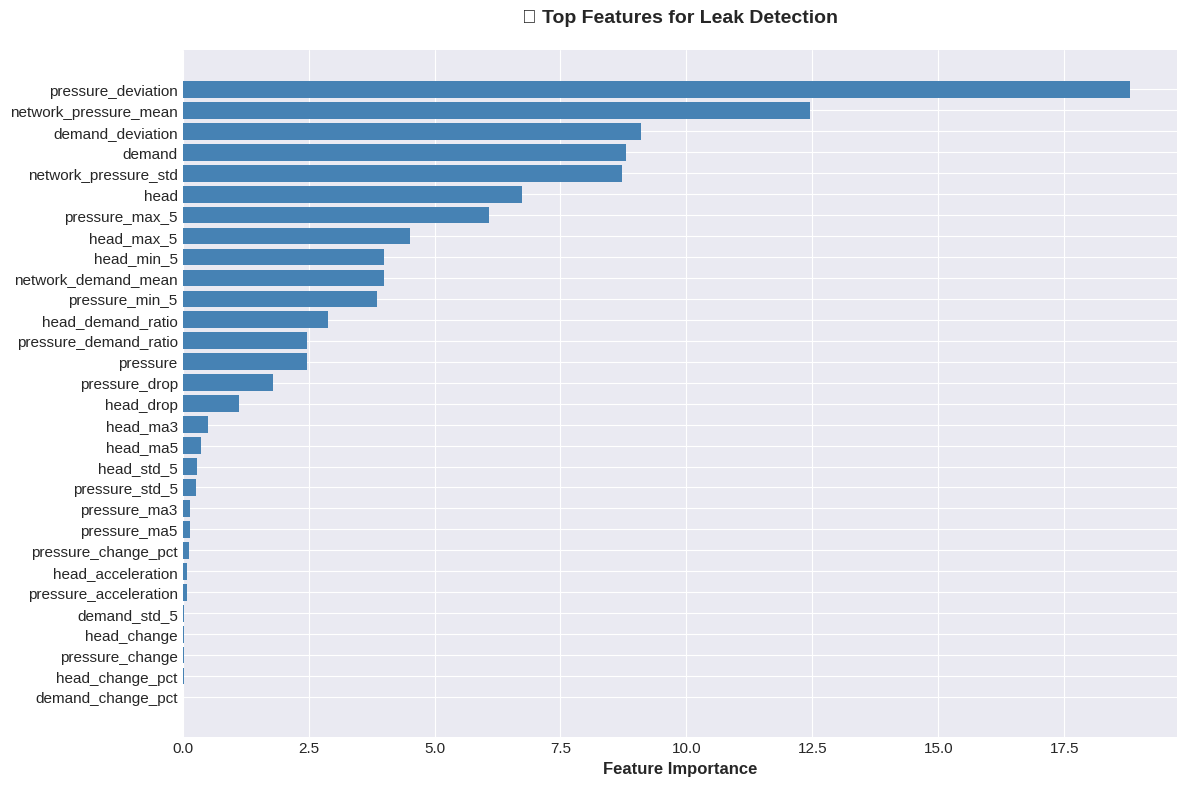

✅ Top 5 features:
   1. pressure_deviation: 18.80
   2. network_pressure_mean: 12.46
   3. demand_deviation: 9.11
   4. demand: 8.80
   5. network_pressure_std: 8.73


In [103]:
# 📊 VISUALIZATION & ANALYSIS (Beautiful plots for reporting!)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score  # Ensure roc_auc_score is imported

# Try to use seaborn style, fallback to default if not available
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("\n📊 Creating visualizations...")

# 1. Feature Importance
try:
    feature_importance = model.get_feature_importance()
    feature_names = feature_cols
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('🎯 Top Features for Leak Detection', fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Top 5 features:")
    for i, (feat, imp) in enumerate(importance_df.head(5).values, 1):
        print(f"   {i}. {feat}: {imp:.2f}")
        
except Exception as e:
    print(f"[WARNING] Could not plot feature importance: {e}")


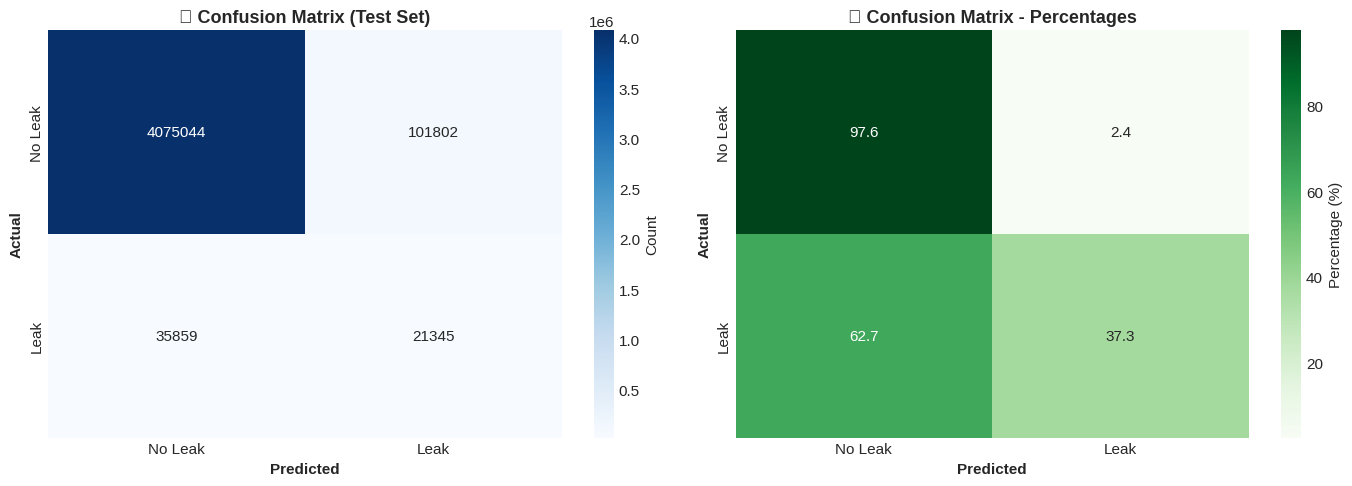

✅ Confusion matrix visualized!


In [104]:
# 2. Confusion Matrix (Beautiful!)
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - Numbers
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Leak', 'Leak'], yticklabels=['No Leak', 'Leak'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('📊 Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11, fontweight='bold')

# Confusion Matrix - Percentages
cm_test_pct = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_test_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=['No Leak', 'Leak'], yticklabels=['No Leak', 'Leak'],
            cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('📊 Confusion Matrix - Percentages', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
print("✅ Confusion matrix visualized!")


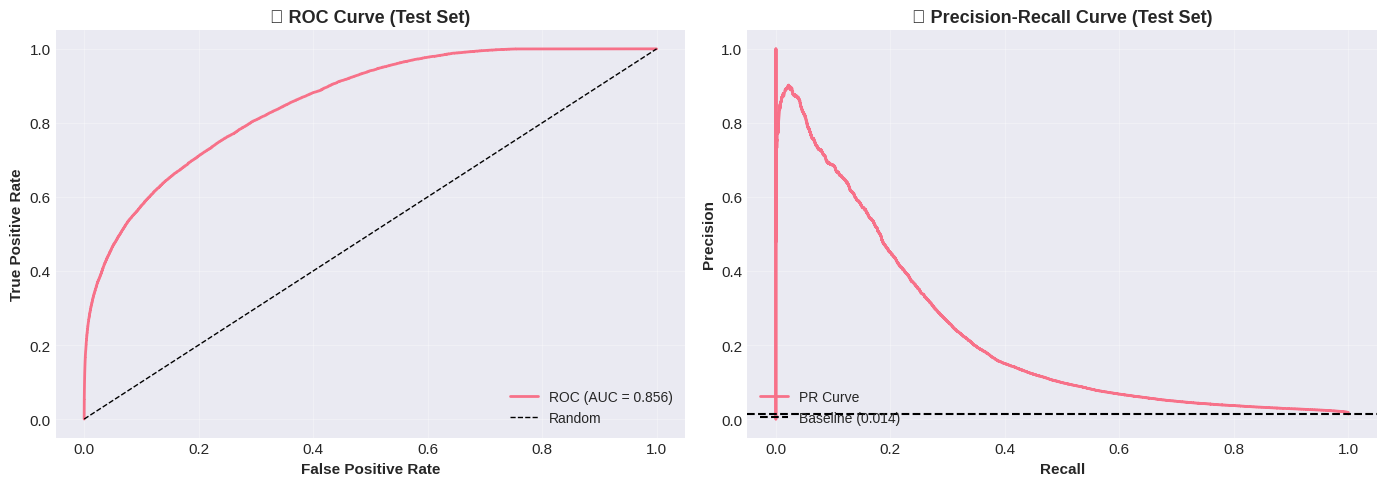

✅ ROC & PR curves visualized!


In [105]:
# 3. ROC Curve & PR Curve
from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_test_proba):.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_title('📈 ROC Curve (Test Set)', fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
axes[1].plot(recall, precision, linewidth=2, label='PR Curve')
axes[1].axhline(y=(y_test.sum() / len(y_test)), color='k', linestyle='--', 
                label=f'Baseline ({y_test.sum() / len(y_test):.3f})')
axes[1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[1].set_title('📈 Precision-Recall Curve (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✅ ROC & PR curves visualized!")


[INFO] Calculating/verifying all metrics for summary table...
   ⚠️  top1_accuracy not found, using 0.0
   ⚠️  top_k_accuracy not found, using 0.0
   ⚠️  top10_accuracy not found, using 0.0
✅ All metrics calculated!


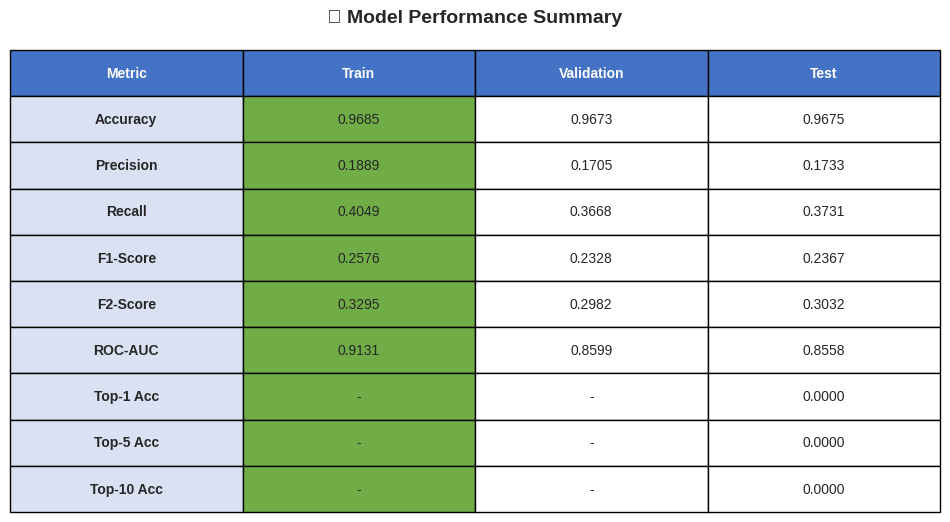

✅ Metrics summary table created!


In [106]:
# 4. Metrics Summary Table (Beautiful!)
from matplotlib.patches import Rectangle

# ✅ SAFE: Tính toán lại tất cả metrics nếu chưa có
print("[INFO] Calculating/verifying all metrics for summary table...")

# Calculate predictions if not exists (dùng try/except thay vì locals())
try:
    _ = y_train_pred
except NameError:
    print("   Computing y_train_pred...")
    y_train_pred = model.predict(X_train_array)

try:
    _ = y_val_pred
except NameError:
    print("   Computing y_val_pred...")
    y_val_pred = model.predict(X_val_array)

try:
    _ = y_test_pred
except NameError:
    print("   Computing y_test_pred...")
    y_test_pred = model.predict(X_test_array)

# Calculate probabilities if not exists
try:
    _ = y_train_proba
except NameError:
    print("   Computing y_train_proba...")
    y_train_proba = model.predict_proba(X_train_array)[:, 1]

try:
    _ = y_val_proba
except NameError:
    print("   Computing y_val_proba...")
    y_val_proba = model.predict_proba(X_val_array)[:, 1]

try:
    _ = y_test_proba
except NameError:
    print("   Computing y_test_proba...")
    y_test_proba = model.predict_proba(X_test_array)[:, 1]

# Calculate all metrics
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred, zero_division=0)
train_rec = recall_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
train_f2 = fbeta_score(y_train, y_train_pred, beta=2.0, zero_division=0)
train_auc = roc_auc_score(y_train, y_train_proba)

val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred, zero_division=0)
val_rec = recall_score(y_val, y_val_pred, zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
val_f2 = fbeta_score(y_val, y_val_pred, beta=2.0, zero_division=0)
val_auc = roc_auc_score(y_val, y_val_proba)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2.0, zero_division=0)
test_auc = roc_auc_score(y_test, y_test_proba)

# Check Top-K metrics (may not exist yet)
try:
    top1_accuracy
except NameError:
    top1_accuracy = 0.0
    print("   ⚠️  top1_accuracy not found, using 0.0")
try:
    top_k_accuracy
except NameError:
    top_k_accuracy = 0.0
    print("   ⚠️  top_k_accuracy not found, using 0.0")
try:
    top10_accuracy
except NameError:
    top10_accuracy = 0.0
    print("   ⚠️  top10_accuracy not found, using 0.0")

print("✅ All metrics calculated!")

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F2-Score', 'ROC-AUC', 
               'Top-1 Acc', 'Top-5 Acc', 'Top-10 Acc'],
    'Train': [f'{train_acc:.4f}', f'{train_prec:.4f}', f'{train_rec:.4f}', 
              f'{train_f1:.4f}', f'{train_f2:.4f}', f'{train_auc:.4f}',
              '-', '-', '-'],
    'Validation': [f'{val_acc:.4f}', f'{val_prec:.4f}', f'{val_rec:.4f}',
                   f'{val_f1:.4f}', f'{val_f2:.4f}', f'{val_auc:.4f}',
                   '-', '-', '-'],
    'Test': [f'{test_acc:.4f}', f'{test_prec:.4f}', f'{test_rec:.4f}',
             f'{test_f1:.4f}', f'{test_f2:.4f}', f'{test_auc:.4f}',
             f'{top1_accuracy:.4f}', f'{top_k_accuracy:.4f}', f'{top10_accuracy:.4f}']
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style header
for i in range(len(metrics_df.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style metrics column
for i in range(1, len(metrics_df) + 1):
    table[(i, 0)].set_facecolor('#D9E1F2')
    table[(i, 0)].set_text_props(weight='bold')

# Highlight best values
for i in range(1, len(metrics_df) + 1):
    values = [float(v) if v != '-' else 0 for v in metrics_df.iloc[i-1, 1:].values]
    best_idx = np.argmax(values) + 1
    table[(i, best_idx)].set_facecolor('#70AD47')

plt.title('📊 Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.show()
print("✅ Metrics summary table created!")


In [107]:
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred, zero_division=0)
val_rec = recall_score(y_val, y_val_pred, zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
val_f2 = fbeta_score(y_val, y_val_pred, beta=2.0, zero_division=0)

In [108]:
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2.0, zero_division=0)

In [109]:
try:
    train_auc = roc_auc_score(y_train, y_train_proba)
    val_auc = roc_auc_score(y_val, y_val_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
except:
    train_auc = val_auc = test_auc = 0.0

In [110]:
print(f"\n{'Metric':<20} {'Train':<12} {'Val':<12} {'Test':<12}")
print("-"*60)
print(f"{'Accuracy':<20} {train_acc:<12.4f} {val_acc:<12.4f} {test_acc:<12.4f}")
print(f"{'Precision':<20} {train_prec:<12.4f} {val_prec:<12.4f} {test_prec:<12.4f}")
print(f"{'Recall':<20} {train_rec:<12.4f} {val_rec:<12.4f} {test_rec:<12.4f}")
print(f"{'F1-Score':<20} {train_f1:<12.4f} {val_f1:<12.4f} {test_f1:<12.4f}")
print(f"{'F-2.0 Score':<20} {train_f2:<12.4f} {val_f2:<12.4f} {test_f2:<12.4f}")
print(f"{'ROC-AUC':<20} {train_auc:<12.4f} {val_auc:<12.4f} {test_auc:<12.4f}")


Metric               Train        Val          Test        
------------------------------------------------------------
Accuracy             0.9685       0.9673       0.9675      
Precision            0.1889       0.1705       0.1733      
Recall               0.4049       0.3668       0.3731      
F1-Score             0.2576       0.2328       0.2367      
F-2.0 Score          0.3295       0.2982       0.3032      
ROC-AUC              0.9131       0.8599       0.8558      


In [111]:
# Classification Report
print("\n[INFO] Classification Report (Test Set):")
print("-" * 80)
print(classification_report(y_test, y_test_pred, target_names=['No Leak', 'Leak']))


[INFO] Classification Report (Test Set):
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Leak       0.99      0.98      0.98   4176846
        Leak       0.17      0.37      0.24     57204

    accuracy                           0.97   4234050
   macro avg       0.58      0.67      0.61   4234050
weighted avg       0.98      0.97      0.97   4234050



In [112]:
# Per-scenario Top-K Evaluation (FIXED: filter by leak time window + fix indexing)
print("\n[INFO] Per-Scenario Top-K Evaluation (within leak time window):")
print("-" * 80)


[INFO] Per-Scenario Top-K Evaluation (within leak time window):
--------------------------------------------------------------------------------


In [113]:
test_metadata = metadata[metadata['scenario_id'].isin(test_scenarios)].copy()
top_k_scores = []
top1_scores = []
top10_scores = []  # Add Top-10 for complete evaluation
top_k = 5  # Default K

In [114]:
# FIX: Convert y_test_proba to array to ensure consistent indexing
y_test_proba_array = np.asarray(y_test_proba) if not isinstance(y_test_proba, np.ndarray) else y_test_proba
test_df_reset = test_df_meta.reset_index(drop=True)  # Use test_df_meta instead of test_df

In [115]:
for scenario_idx, (_, meta) in enumerate(test_metadata.iterrows()):
    scenario_id = int(meta['scenario_id'])
    leak_node = str(meta['leak_node'])
    start_time = float(meta['start_time_s'])
    end_time = float(meta['end_time_s'])
    
    # Normalize leak_node
    if '.' in leak_node:
        leak_node_normalized = str(int(float(leak_node)))
    else:
        leak_node_normalized = leak_node
    
    # FIX: Filter by leak time window FIRST
    scenario_mask = (
        (test_df_reset['scenario_id'] == scenario_id) &
        (test_df_reset['timestamp'] >= start_time) &
        (test_df_reset['timestamp'] <= end_time)
    )
    
    if scenario_mask.sum() == 0:
        continue
    
    # Get data within leak window
    scenario_data = test_df_reset[scenario_mask].copy()
    scenario_data_indices = scenario_data.index.values  # Array indices in reset DataFrame
    
    # FIX: Use correct indexing for probabilities
    if len(scenario_data_indices) > 0:
        scenario_proba = y_test_proba_array[scenario_data_indices]
    else:
        continue
    
    # Group by node_id and aggregate (max probability per node in leak window)
    scenario_data['proba'] = scenario_proba
    node_proba = scenario_data.groupby('node_id')['proba'].max().sort_values(ascending=False)
    
    if len(node_proba) == 0:
        continue
    
    # Get top-k nodes (Top-1, Top-5, Top-10)
    k = min(top_k, len(node_proba))
    k10 = min(10, len(node_proba))
    top_k_nodes = node_proba.head(k).index.astype(str).tolist()
    top10_nodes = node_proba.head(k10).index.astype(str).tolist()
    top1_node = str(node_proba.index[0]) if len(node_proba) > 0 else None
    
    # Check if leak_node is in top-k
    is_leak_in_topk = leak_node_normalized in top_k_nodes if top_k_nodes else False
    is_leak_in_top10 = leak_node_normalized in top10_nodes if top10_nodes else False
    is_leak_top1 = (top1_node == leak_node_normalized) if top1_node else False
    
    top_k_scores.append(is_leak_in_topk)
    top10_scores.append(is_leak_in_top10)
    top1_scores.append(is_leak_top1)
    
    if scenario_idx < 5:  # Show first 5 scenarios
        print(f"  Scenario {scenario_id}: Leak node '{leak_node_normalized}' "
              f"in top-{k}? {is_leak_in_topk} | top-10? {is_leak_in_top10} | top-1? {is_leak_top1}")

  Scenario 24: Leak node '1581' in top-5? False | top-10? False | top-1? False
  Scenario 30: Leak node '868' in top-5? False | top-10? False | top-1? False
  Scenario 50: Leak node '184' in top-5? False | top-10? False | top-1? False
  Scenario 52: Leak node '563' in top-5? False | top-10? False | top-1? False
  Scenario 57: Leak node '13' in top-5? True | top-10? True | top-1? True


In [116]:
top_k_accuracy = np.mean(top_k_scores) if top_k_scores else 0.0
top10_accuracy = np.mean(top10_scores) if top10_scores else 0.0
top1_accuracy = np.mean(top1_scores) if top1_scores else 0.0
print(f"\n[OK] Top-1 Accuracy: {top1_accuracy:.4f} ({100*top1_accuracy:.2f}%)")
print(f"[OK] Top-5 Accuracy: {top_k_accuracy:.4f} ({100*top_k_accuracy:.2f}%)")
print(f"[OK] Top-10 Accuracy: {top10_accuracy:.4f} ({100*top10_accuracy:.2f}%)")


[OK] Top-1 Accuracy: 0.1333 (13.33%)
[OK] Top-5 Accuracy: 0.3289 (32.89%)
[OK] Top-10 Accuracy: 0.4444 (44.44%)


In [117]:
# Confusion Matrix
print("\n[INFO] Confusion Matrix (Test Set):")
print("-" * 80)
cm = confusion_matrix(y_test, y_test_pred)
print(f"                Predicted")
print(f"              No Leak   Leak")
print(f"Actual No Leak   {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"       Leak      {cm[1,0]:6d}  {cm[1,1]:6d}")


[INFO] Confusion Matrix (Test Set):
--------------------------------------------------------------------------------
                Predicted
              No Leak   Leak
Actual No Leak   4075044  101802
       Leak       35859   21345


In [118]:
# Feature Importance
print("\n[INFO] Feature Importance:")
print("-" * 80)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.to_string(index=False))
print(f"\n[INFO] Top 3 most important features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance']:.6f}")


[INFO] Feature Importance:
--------------------------------------------------------------------------------
              feature  importance
   pressure_deviation   18.798177
network_pressure_mean   12.456887
     demand_deviation    9.107399
               demand    8.803756
 network_pressure_std    8.727444
                 head    6.744459
       pressure_max_5    6.082091
           head_max_5    4.522170
           head_min_5    4.004556
  network_demand_mean    3.998104
       pressure_min_5    3.864560
    head_demand_ratio    2.884638
pressure_demand_ratio    2.472384
             pressure    2.469825
        pressure_drop    1.802719
            head_drop    1.109752
             head_ma3    0.513838
             head_ma5    0.373010
           head_std_5    0.276936
       pressure_std_5    0.264568
         pressure_ma3    0.149873
         pressure_ma5    0.149105
  pressure_change_pct    0.127434
    head_acceleration    0.095546
pressure_acceleration    0.090944
       

In [119]:
# 9. Save Model
print("\n9. SAVE MODEL:")
print("-" * 80)


9. SAVE MODEL:
--------------------------------------------------------------------------------


In [120]:
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

In [121]:
# Save model
model_file = model_dir / "leak_detection_model.pkl"
with open(model_file, 'wb') as f:
    pickle.dump(model, f)
print(f"[OK] Model saved: {model_file}")

[OK] Model saved: models/leak_detection_model.pkl


In [122]:
# Save scaler (if exists)
if scaler is not None:
    scaler_file = model_dir / "scaler.pkl"
    with open(scaler_file, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"[OK] Scaler saved: {scaler_file}")
else:
    print("[INFO] No scaler (CatBoost uses original features)")

[INFO] No scaler (CatBoost uses original features)


In [123]:
# Check if best threshold was found
try:
    best_threshold
except:
    best_threshold = 0.5

In [124]:
# Save metadata
# Note: reservoir_nodes not defined (filter removed to avoid misclassification)
model_metadata = {
    'feature_cols': feature_cols,
    'reservoir_nodes': [],  # Not filtered (temporarily removed to avoid misclassification)
    'n_train': len(X_train),
    'n_val': len(X_val),
    'n_test': len(X_test),
    'train_acc': float(train_acc),
    'train_prec': float(train_prec),
    'train_rec': float(train_rec),
    'train_f1': float(train_f1),
    'train_f2': float(train_f2),
    'val_acc': float(val_acc),
    'val_prec': float(val_prec),
    'val_rec': float(val_rec),
    'val_f1': float(val_f1),
    'val_f2': float(val_f2),
    'test_acc': float(test_acc),
    'test_prec': float(test_prec),
    'test_rec': float(test_rec),
    'test_f1': float(test_f1),
    'test_f2': float(test_f2),
    'test_auc': float(test_auc),
    'top_k_accuracy': float(top_k_accuracy),  # Top-5
    'top10_accuracy': float(top10_accuracy),  # Top-10
    'top1_accuracy': float(top1_accuracy),  # Top-1
    'use_smote': use_smote,
    'best_threshold': float(best_threshold),
    'best_metric': best_metric_name,
    'labeling_method': 'exact_leak_node_in_time_window'
}

In [125]:
import json
metadata_file = model_dir / "model_metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"[OK] Metadata saved: {metadata_file}")

[OK] Metadata saved: models/model_metadata.json


In [126]:
print("\n" + "="*80)
print("TRAINING HOAN TAT!")
print("="*80)
print("\nCac file da luu:")
print(f"  1. {model_file} - Model")
if scaler is not None:
    print(f"  2. {scaler_file} - Scaler")
else:
    print(f"  2. No scaler saved (CatBoost uses original features)")
print(f"  3. {metadata_file} - Metadata")
print("\nDe su dung model:")
print("  python scripts/predict_leak.py <scenario_id>")


TRAINING HOAN TAT!

Cac file da luu:
  1. models/leak_detection_model.pkl - Model
  2. No scaler saved (CatBoost uses original features)
  3. models/model_metadata.json - Metadata

De su dung model:
  python scripts/predict_leak.py <scenario_id>
